#### **Use Grid Search to Find the most Informative Peaks**

Import Libraries

In [1]:
import pandas as pd
from scipy.signal import find_peaks
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from scipy.signal import peak_widths, peak_prominences
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.metrics import accuracy_score
import sys
sys.path.append('..')
from Cleaning_and_Evaluation import *

Read the spectral data

In [2]:
#df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")
#df = pd.read_csv("../../data/exosomes.raw_spectrum_400-1800.csv")
#df = pd.read_csv("../../data/current_clean_spectrum.csv", index_col=0)
df = pd.read_csv("../../data/current_clean_spectrum.csv")

In [3]:
df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance
0,201210-1-00,293,400.22778,201210-1,Normal,-0.145034
1,201210-1-00,294,400.91116,201210-1,Normal,-0.145878
2,201210-1-00,295,401.59454,201210-1,Normal,-0.146846
3,201210-1-00,296,402.27789,201210-1,Normal,-0.147930
4,201210-1-00,297,402.96127,201210-1,Normal,-0.149124
...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,210526-3,Hyperglycemia,-1.512976
6239201,210526-3-09,2338,1797.72200,210526-3,Hyperglycemia,-1.502732
6239202,210526-3-09,2339,1798.40550,210526-3,Hyperglycemia,-1.493562
6239203,210526-3-09,2340,1799.08890,210526-3,Hyperglycemia,-1.485648


In [4]:
#df['Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: svn_normalise(x))

#### **Example using one Spectrum**

In [5]:
sample = df[df['SpecID'] == "210526-3-04"]
print(sample)

              SpecID   Seq  WaveNumber     SurID         Status  Absorbance
6206421  210526-3-04   293   400.22778  210526-3  Hyperglycemia   -0.575207
6206422  210526-3-04   294   400.91116  210526-3  Hyperglycemia   -0.553376
6206423  210526-3-04   295   401.59454  210526-3  Hyperglycemia   -0.535873
6206424  210526-3-04   296   402.27789  210526-3  Hyperglycemia   -0.522354
6206425  210526-3-04   297   402.96127  210526-3  Hyperglycemia   -0.512488
...              ...   ...         ...       ...            ...         ...
6208465  210526-3-04  2337  1797.03870  210526-3  Hyperglycemia   -1.024396
6208466  210526-3-04  2338  1797.72200  210526-3  Hyperglycemia   -1.011266
6208467  210526-3-04  2339  1798.40550  210526-3  Hyperglycemia   -0.997189
6208468  210526-3-04  2340  1799.08890  210526-3  Hyperglycemia   -0.982139
6208469  210526-3-04  2341  1799.77220  210526-3  Hyperglycemia   -0.966092

[2049 rows x 6 columns]


Find Peaks Within the spectrum.

In [6]:
#peaks, _ = find_peaks(x=sample['Absorbance'], distance=152, prominence=42, width=6)
peaks, _ = find_peaks(x=sample['Absorbance'])

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

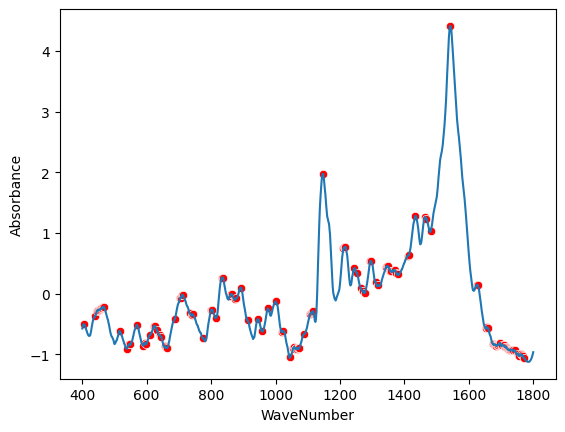

In [7]:
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[peaks], x="WaveNumber", y="Absorbance", color="red")

As you can see, it does not properly find the peaks, so we have to tune the peak finding parameters.

In [12]:
tuned_peaks, _ = find_peaks(x=sample['Absorbance'], distance=152, prominence=0.25, width=6)

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

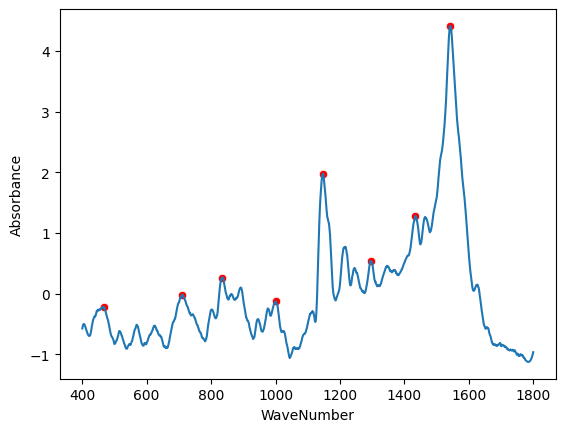

In [13]:
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[tuned_peaks], x="WaveNumber", y="Absorbance", color="red")

#### **Find the best Peak Finding Parameters**

Create a field for each wavelength.

Train an Extra Trees Classifier

In [14]:
def evaluate_extra_trees(df):

    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']

    # Creating the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)
    
    # Using GroupKFold for classification tasks
    cv = GroupKFold(n_splits=10)

    scores = []
    for train_index, test_index in cv.split(X, y, groups):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train the Extra Trees classifier
        et.fit(X_train, y_train)
        predictions = et.predict(X_test)
        
        # Evaluate the model
        score = accuracy_score(y_test, predictions)
        scores.append(score)
    
    # Displaying the results
    print(f'{et.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

In [15]:
def evaluate_svm_with_grid_search(df):
    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']

    # Define the SVM classifier
    svm = SVC(random_state=1234)

    param_grid = {
    'C': [1, 10** 4, 10**6],
    'gamma': ['scale']
    }
    
    # Define the GroupKFold split strategy
    cv = GroupKFold(n_splits=5)

    # Initialise the GridSearchCV object
    grid_search = GridSearchCV(svm, param_grid, scoring='accuracy', cv=cv, n_jobs=-1, verbose=1)

    # Fit the model with the grid search
    # Note: GridSearchCV doesn't directly accept 'groups' as a parameter in 'fit', so we include them in 'cv' splits
    grid_search.fit(X, y, groups=groups)

    # Best parameter set found:
    print(f'Best parameters found: {grid_search.best_params_}')
    
    # Best cross-validation score:
    print(f'Best cross-validation accuracy: {grid_search.best_score_:.4f}')

    # Optionally, you can return the best estimator or the full GridSearchCV object for further inspection or predictions
    return grid_search.best_estimator_

In [16]:
def evaluate_extra_trees_with_grid_search(df):
    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']

    # Define the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)

    param_grid = {
        'n_estimators': [100, 200, 300],  # Number of trees in the forest
        'criterion': ['gini', 'entropy'],  # Function to measure the quality of a split
        'max_depth': [None, 10, 20],  # Maximum depth of the tree
    }
    
    # Define the GroupKFold split strategy
    cv = GroupKFold(n_splits=5)

    # Initialise the GridSearchCV object
    grid_search = GridSearchCV(et, param_grid, scoring='accuracy', cv=cv, n_jobs=-1, verbose=1)

    # Fit the model with the grid search
    grid_search.fit(X, y, groups=groups)

    # Best parameter set found:
    print(f'Best parameters found: {grid_search.best_params_}')
    
    # Best cross-validation score:
    print(f'Best cross-validation accuracy: {grid_search.best_score_:.4f}')

    # Optionally, you can return the best estimator or the full GridSearchCV object for further inspection or predictions
    return grid_search.best_estimator_

---

#### **1. Using Peak Statistics**

In [17]:
backup = df

In [18]:
statuses = df[['SpecID', 'Status','SurID']].drop_duplicates()

This uses statistical properties of the peaks in each sample to be used as additional features.

In [19]:
peaks = []
widths = []
prominences = []

# Find the index and width of each peak
for _, group in df.groupby('SpecID'):

    #peak_index, _ = find_peaks(x=group['Absorbance'], distance=152, prominence=42, width=6)
    peak_index, _ = find_peaks(x=group['Absorbance'], distance=10, width=1)


    # Calculate the widths of each peak
    widths += list(peak_widths(group['Absorbance'], peaks=peak_index, rel_height=0.5)[0])

    # Calculate prominence of each peak
    prominences += list(peak_prominences(group['Absorbance'], peaks=peak_index)[0])

    # Find the index of the peak within the full dataframe
    peaks += list(group.iloc[peak_index].index.values)

peaks_df = df.iloc[peaks]
peaks_df['PeakWidths'] = widths
peaks_df['PeakProminences'] = prominences

/tmp/ipykernel_19583/272031481.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['PeakWidths'] = widths
/tmp/ipykernel_19583/272031481.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['PeakProminences'] = prominences


In [20]:
peaks_df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance,PeakWidths,PeakProminences
39,201210-1-00,332,426.87927,201210-1,Normal,-0.204230,1.527948,0.007112
52,201210-1-00,345,435.76309,201210-1,Normal,-0.183654,8.162783,0.088652
69,201210-1-00,362,447.38040,201210-1,Normal,-0.216862,1.753954,0.017891
82,201210-1-00,375,456.26425,201210-1,Normal,-0.010649,30.836138,0.271329
98,201210-1-00,391,467.19818,201210-1,Normal,-0.018985,3.856546,0.034692
...,...,...,...,...,...,...,...,...
6228874,210526-3-49,2256,1741.68570,210526-3,Hyperglycemia,-1.330735,2.950797,0.016613
6228889,210526-3-49,2271,1751.93630,210526-3,Hyperglycemia,-1.435981,2.856323,0.045145
6228899,210526-3-49,2281,1758.76990,210526-3,Hyperglycemia,-1.538985,2.103793,0.013493
6228909,210526-3-49,2291,1765.60360,210526-3,Hyperglycemia,-1.498198,4.710222,0.070480


In [21]:
#sns.scatterplot(data=peaks_df, x="WaveNumber", y="Absorbance", hue='Status')

Standard Deviation of the Absorbances appears to have a positive affect on accuracy.

In [22]:
# Create a new DataFrame for the summary statistics
peak_stats = peaks_df.groupby('SpecID').agg({
    'Absorbance': ['mean', 'std', 'count', 'max', 'min'],
    'PeakWidths': ['mean', 'std', 'max', 'min'],
    'PeakProminences': ['mean', 'std', 'max', 'min']
}).reset_index()

# Flatten the multi-level columns and customize the names
peak_stats.columns = ['SpecID',
                      'PeakAbsorbance_mean', 'PeakAbsorbance_std', 'PeakAbsorbance_count', 'PeakAbsorbance_max', 'PeakAbsorbance_min',
                      'PeakWidths_mean', 'PeakWidths_std', 'PeakWidths_max', 'PeakWidths_min',
                      'PeakProminences_mean', 'PeakProminences_std', 'PeakProminences_max', 'PeakProminences_min']

In [23]:
# # Create a new DataFrame for the summary statistics
# peak_stats = peaks_df.groupby('SpecID').agg({
#     'PeakWidths': ['mean', 'std', 'max', 'min'],
#     'PeakProminences': ['mean', 'std', 'max', 'min']
# }).reset_index()

# # Flatten the multi-level columns and customize the names
# peak_stats.columns = ['SpecID',
#                       'PeakWidths_mean', 'PeakWidths_std', 'PeakWidths_max', 'PeakWidths_min',
#                       'PeakProminences_mean', 'PeakProminences_std', 'PeakProminences_max', 'PeakProminences_min']

In [24]:
peak_stats.head()

,SpecID,PeakAbsorbance_mean,PeakAbsorbance_std,PeakAbsorbance_count,PeakAbsorbance_max,PeakAbsorbance_min,PeakWidths_mean,PeakWidths_std,PeakWidths_max,PeakWidths_min,PeakProminences_mean,PeakProminences_std,PeakProminences_max,PeakProminences_min
0,201210-1-00,0.172433,1.103462,59,3.498906,-1.742003,17.375263,33.201098,204.174021,1.029708,0.435608,1.010671,4.840195,0.004691
1,201210-1-01,0.093636,1.148565,44,2.984479,-1.261778,21.681214,30.582153,159.529397,1.125432,0.558483,1.086717,4.316852,0.002069
2,201210-1-02,0.170803,1.297260,45,7.536678,-0.791008,16.901754,18.454047,72.734087,1.041594,0.411826,1.358464,8.325781,0.001839
3,201210-1-03,0.070841,1.274653,36,3.705094,-1.343061,20.001866,20.917069,70.495437,1.064298,0.537403,1.251934,4.802881,0.001113
4,201210-1-04,0.071091,1.080884,49,3.422707,-1.720276,20.739270,35.531264,200.658459,1.010958,0.354370,0.854013,5.180989,0.001291


In [25]:
peak_stats.shape

(3045, 14)

In [26]:
peak_stats = pd.merge(statuses, peak_stats, on='SpecID', how='left')
peak_stats = peak_stats.set_index('SpecID')
peak_stats = peak_stats.fillna(0)

In [27]:
peak_stats.shape

(3045, 15)

In [28]:
peak_stats.head()

,Status,SurID,PeakAbsorbance_mean,PeakAbsorbance_std,PeakAbsorbance_count,PeakAbsorbance_max,PeakAbsorbance_min,PeakWidths_mean,PeakWidths_std,PeakWidths_max,PeakWidths_min,PeakProminences_mean,PeakProminences_std,PeakProminences_max,PeakProminences_min
SpecID,,,,,,,,,,,,,,,
201210-1-00,Normal,201210-1,0.172433,1.103462,59,3.498906,-1.742003,17.375263,33.201098,204.174021,1.029708,0.435608,1.010671,4.840195,0.004691
201210-1-01,Normal,201210-1,0.093636,1.148565,44,2.984479,-1.261778,21.681214,30.582153,159.529397,1.125432,0.558483,1.086717,4.316852,0.002069
201210-1-02,Normal,201210-1,0.170803,1.297260,45,7.536678,-0.791008,16.901754,18.454047,72.734087,1.041594,0.411826,1.358464,8.325781,0.001839
201210-1-03,Normal,201210-1,0.070841,1.274653,36,3.705094,-1.343061,20.001866,20.917069,70.495437,1.064298,0.537403,1.251934,4.802881,0.001113
201210-1-04,Normal,201210-1,0.071091,1.080884,49,3.422707,-1.720276,20.739270,35.531264,200.658459,1.010958,0.354370,0.854013,5.180989,0.001291


In [29]:
evaluate_extra_trees(peak_stats)

ExtraTreesClassifier Cross-Validation Accuracy: 0.3604 +/- 0.0991


In [30]:
evaluate_extra_trees_with_grid_search(peak_stats)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


Best parameters found: {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 200}
Best cross-validation accuracy: 0.3712


ExtraTreesClassifier(criterion='entropy', n_estimators=200, random_state=1234)

> ##### **Combine these stats with the full spectra**

In [31]:
df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance
0,201210-1-00,293,400.22778,201210-1,Normal,-0.145034
1,201210-1-00,294,400.91116,201210-1,Normal,-0.145878
2,201210-1-00,295,401.59454,201210-1,Normal,-0.146846
3,201210-1-00,296,402.27789,201210-1,Normal,-0.147930
4,201210-1-00,297,402.96127,201210-1,Normal,-0.149124
...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,210526-3,Hyperglycemia,-1.512976
6239201,210526-3-09,2338,1797.72200,210526-3,Hyperglycemia,-1.502732
6239202,210526-3-09,2339,1798.40550,210526-3,Hyperglycemia,-1.493562
6239203,210526-3-09,2340,1799.08890,210526-3,Hyperglycemia,-1.485648


In [32]:
wavelength_df = prepare_wavelength_df(df, 'Absorbance')
wavelength_df.head()

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,SurID,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,-0.145034,-0.145878,-0.146846,-0.147930,-0.149124,-0.150419,-0.151809,-0.153285,-0.154842,-0.156472,...,-1.345058,-1.374955,-1.411756,-1.456164,-1.508905,-1.570731,-1.642422,-1.724783,201210-1,Normal
201210-1-01,-0.113925,-0.095859,-0.078315,-0.061298,-0.044809,-0.028851,-0.013427,0.001461,0.015811,0.029622,...,-1.276142,-1.270276,-1.264736,-1.259661,-1.255195,-1.251489,-1.248700,-1.246995,201210-1,Normal
201210-1-02,0.319805,0.294851,0.272852,0.253610,0.236933,0.222637,0.210540,0.200470,0.192256,0.185737,...,-0.786004,-0.783888,-0.781223,-0.778007,-0.774241,-0.769923,-0.765056,-0.759642,201210-1,Normal
201210-1-03,0.320669,0.319732,0.317912,0.315311,0.312032,0.308171,0.303821,0.299071,0.294007,0.288710,...,-1.087505,-1.084745,-1.081706,-1.078409,-1.074875,-1.071124,-1.067182,-1.063074,201210-1,Normal
201210-1-04,1.090330,1.001816,0.922056,0.850546,0.786796,0.730331,0.680686,0.637415,0.600081,0.568264,...,-1.801045,-1.805067,-1.809630,-1.814870,-1.820931,-1.827960,-1.836115,-1.845557,201210-1,Normal


In [33]:
evaluate_extra_trees(wavelength_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.6161 +/- 0.1013


In [34]:
evaluate_extra_trees_with_grid_search(wavelength_df)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


Best parameters found: {'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 300}
Best cross-validation accuracy: 0.6233


ExtraTreesClassifier(criterion='entropy', max_depth=20, n_estimators=300,
                     random_state=1234)

In [35]:
stats_and_spectrum = wavelength_df.merge(peak_stats.drop(columns=['SurID', 'Status']), on='SpecID')
stats_and_spectrum.columns = stats_and_spectrum.columns.astype(str)
stats_and_spectrum.head()

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,PeakAbsorbance_max,PeakAbsorbance_min,PeakWidths_mean,PeakWidths_std,PeakWidths_max,PeakWidths_min,PeakProminences_mean,PeakProminences_std,PeakProminences_max,PeakProminences_min
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,-0.145034,-0.145878,-0.146846,-0.147930,-0.149124,-0.150419,-0.151809,-0.153285,-0.154842,-0.156472,...,3.498906,-1.742003,17.375263,33.201098,204.174021,1.029708,0.435608,1.010671,4.840195,0.004691
201210-1-01,-0.113925,-0.095859,-0.078315,-0.061298,-0.044809,-0.028851,-0.013427,0.001461,0.015811,0.029622,...,2.984479,-1.261778,21.681214,30.582153,159.529397,1.125432,0.558483,1.086717,4.316852,0.002069
201210-1-02,0.319805,0.294851,0.272852,0.253610,0.236933,0.222637,0.210540,0.200470,0.192256,0.185737,...,7.536678,-0.791008,16.901754,18.454047,72.734087,1.041594,0.411826,1.358464,8.325781,0.001839
201210-1-03,0.320669,0.319732,0.317912,0.315311,0.312032,0.308171,0.303821,0.299071,0.294007,0.288710,...,3.705094,-1.343061,20.001866,20.917069,70.495437,1.064298,0.537403,1.251934,4.802881,0.001113
201210-1-04,1.090330,1.001816,0.922056,0.850546,0.786796,0.730331,0.680686,0.637415,0.600081,0.568264,...,3.422707,-1.720276,20.739270,35.531264,200.658459,1.010958,0.354370,0.854013,5.180989,0.001291


In [36]:
evaluate_extra_trees(stats_and_spectrum)

ExtraTreesClassifier Cross-Validation Accuracy: 0.6015 +/- 0.0993


In [37]:
evaluate_extra_trees_with_grid_search(stats_and_spectrum)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


Best parameters found: {'criterion': 'gini', 'max_depth': None, 'n_estimators': 300}
Best cross-validation accuracy: 0.6209


ExtraTreesClassifier(n_estimators=300, random_state=1234)

---

#### **2. Creating a uniform Peak Featureset**

This aims to create a featureset using peaks within wavenumber intervals.

Assign Peaks to bins of a fixed wavelength interval.

In [38]:
# Define a function to calculate the bin for a given wavenumber with a specified bin size
def calculate_bin_interval(wavenumber, bin_size):
    bin_start = int((wavenumber - 200) / bin_size) * bin_size + 200
    bin_end = bin_start + bin_size
    return f"{bin_start}-{bin_end}"

In [39]:
# Set the bin size
bin_size = 25

# Add a "Bin" column to the DataFrame
peaks_df['Bin'] = peaks_df['WaveNumber'].apply(lambda x: calculate_bin_interval(x, bin_size))

/tmp/ipykernel_19583/3718610318.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['Bin'] = peaks_df['WaveNumber'].apply(lambda x: calculate_bin_interval(x, bin_size))


In [40]:
peaks_df.head()

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance,PeakWidths,PeakProminences,Bin
39,201210-1-00,332,426.87927,201210-1,Normal,-0.204230,1.527948,0.007112,425-450
52,201210-1-00,345,435.76309,201210-1,Normal,-0.183654,8.162783,0.088652,425-450
69,201210-1-00,362,447.38040,201210-1,Normal,-0.216862,1.753954,0.017891,425-450
82,201210-1-00,375,456.26425,201210-1,Normal,-0.010649,30.836138,0.271329,450-475
98,201210-1-00,391,467.19818,201210-1,Normal,-0.018985,3.856546,0.034692,450-475


Set the bins as columns with the peak absorbances, widths and prominences as the values.

If no peaks appear in a bin the value is set to 0.

If multiple peaks appear their properties are aggregated.

In [41]:
# Pivot table with 'Absorbance', 'PeakWidths', and 'PeakProminences' as values
peak_bins = peaks_df.pivot_table(index='SpecID', columns='Bin', values=['Absorbance', 'PeakWidths', 'PeakProminences'], aggfunc='max')
peak_bins.columns = [f"{col[0]}_{col[1]}" for col in peak_bins.columns]  # Combine column names
peak_bins.reset_index(inplace=True)

# Merge with 'Status' information
statuses = peaks_df[['SpecID', 'Status', 'SurID']].drop_duplicates()
peak_bins = pd.merge(peak_bins, statuses, on='SpecID')

# Set 'SpecID' as the index
peak_bins.set_index('SpecID', inplace=True)

# Fill NaN values with 0
peak_bins.fillna(0, inplace=True)

In [42]:
peak_bins.head()

,Absorbance_1000-1025,Absorbance_1025-1050,Absorbance_1050-1075,Absorbance_1075-1100,Absorbance_1100-1125,Absorbance_1125-1150,Absorbance_1150-1175,Absorbance_1175-1200,Absorbance_1200-1225,Absorbance_1225-1250,...,PeakWidths_800-825,PeakWidths_825-850,PeakWidths_850-875,PeakWidths_875-900,PeakWidths_900-925,PeakWidths_925-950,PeakWidths_950-975,PeakWidths_975-1000,Status,SurID
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,1.629620,0.688229,0.670361,0.207960,-0.693493,-0.271763,-0.601120,-0.931320,-1.132908,0.144748,...,17.695023,0.000000,17.772836,122.891699,0.000000,1.396270,0.0,0.000000,Normal,201210-1
201210-1-01,0.863446,0.000000,0.188242,0.000000,-0.845043,-0.461795,-0.436456,-0.715645,-1.259516,-1.027596,...,0.000000,0.000000,9.749188,0.000000,99.243921,19.199533,0.0,0.000000,Normal,201210-1
201210-1-02,0.404994,0.582103,-0.133073,-0.177061,0.000000,-0.092902,0.000000,-0.548663,-0.425065,0.000000,...,1.957015,0.000000,4.895613,0.000000,35.166775,2.584313,0.0,9.437857,Normal,201210-1
201210-1-03,0.000000,0.000000,0.222784,0.000000,-0.184418,0.000000,2.153413,0.000000,0.000000,-0.385156,...,0.000000,2.801895,0.000000,0.000000,64.037071,0.000000,0.0,61.892904,Normal,201210-1
201210-1-04,0.118618,-0.438987,-0.469008,-0.843070,0.000000,-0.366367,-0.169748,0.229998,-0.393862,0.000000,...,1.010958,0.000000,133.011467,3.874509,14.603562,3.582860,0.0,0.000000,Normal,201210-1


In [43]:
evaluate_extra_trees(peak_bins)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5322 +/- 0.1165


In [44]:
evaluate_extra_trees_with_grid_search(peak_bins)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters found: {'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 300}
Best cross-validation accuracy: 0.5609


ExtraTreesClassifier(criterion='entropy', max_depth=20, n_estimators=300,
                     random_state=1234)

In [45]:
bins_and_spectrum = wavelength_df.merge(peak_stats.drop(columns=['SurID', 'Status']), on='SpecID')
bins_and_spectrum.columns = stats_and_spectrum.columns.astype(str)
bins_and_spectrum.head()

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,PeakAbsorbance_max,PeakAbsorbance_min,PeakWidths_mean,PeakWidths_std,PeakWidths_max,PeakWidths_min,PeakProminences_mean,PeakProminences_std,PeakProminences_max,PeakProminences_min
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,-0.145034,-0.145878,-0.146846,-0.147930,-0.149124,-0.150419,-0.151809,-0.153285,-0.154842,-0.156472,...,3.498906,-1.742003,17.375263,33.201098,204.174021,1.029708,0.435608,1.010671,4.840195,0.004691
201210-1-01,-0.113925,-0.095859,-0.078315,-0.061298,-0.044809,-0.028851,-0.013427,0.001461,0.015811,0.029622,...,2.984479,-1.261778,21.681214,30.582153,159.529397,1.125432,0.558483,1.086717,4.316852,0.002069
201210-1-02,0.319805,0.294851,0.272852,0.253610,0.236933,0.222637,0.210540,0.200470,0.192256,0.185737,...,7.536678,-0.791008,16.901754,18.454047,72.734087,1.041594,0.411826,1.358464,8.325781,0.001839
201210-1-03,0.320669,0.319732,0.317912,0.315311,0.312032,0.308171,0.303821,0.299071,0.294007,0.288710,...,3.705094,-1.343061,20.001866,20.917069,70.495437,1.064298,0.537403,1.251934,4.802881,0.001113
201210-1-04,1.090330,1.001816,0.922056,0.850546,0.786796,0.730331,0.680686,0.637415,0.600081,0.568264,...,3.422707,-1.720276,20.739270,35.531264,200.658459,1.010958,0.354370,0.854013,5.180989,0.001291


In [46]:
evaluate_extra_trees(bins_and_spectrum)

ExtraTreesClassifier Cross-Validation Accuracy: 0.6015 +/- 0.0993


In [47]:
evaluate_extra_trees_with_grid_search(bins_and_spectrum)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


Best parameters found: {'criterion': 'gini', 'max_depth': None, 'n_estimators': 300}
Best cross-validation accuracy: 0.6209


ExtraTreesClassifier(n_estimators=300, random_state=1234)